In [12]:
%load_ext autoreload

import os, sys
import networkx as nx

sys.path.insert(0, "../")

%autoreload 2
from mikg.kgraph import *
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

import random
random.seed(42)

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
kg = KGraph()
kg.load_kgraph("../data/initial_base_graph.out")

In [3]:
exprDF = pd.read_csv("../seq_data/expression_ctzone_mean_df.tsv", sep="\t")

In [4]:
exprDFs = {}

for group in exprDF.group.unique():
    exprDFs[group] = exprDF[exprDF.group == group].copy()

print([x for x in exprDFs])

['Adipocyte_BZ', 'Adipocyte_CTRL', 'Adipocyte_FZ', 'Adipocyte_IZ', 'Adipocyte_RZ', 'Cardiomyocyte_BZ', 'Cardiomyocyte_CTRL', 'Cardiomyocyte_FZ', 'Cardiomyocyte_IZ', 'Cardiomyocyte_RZ', 'Cycling cells_BZ', 'Cycling cells_CTRL', 'Cycling cells_FZ', 'Cycling cells_IZ', 'Cycling cells_RZ', 'Endothelial_BZ', 'Endothelial_CTRL', 'Endothelial_FZ', 'Endothelial_IZ', 'Endothelial_RZ', 'Fibroblast_BZ', 'Fibroblast_CTRL', 'Fibroblast_FZ', 'Fibroblast_IZ', 'Fibroblast_RZ', 'Lymphoid_BZ', 'Lymphoid_CTRL', 'Lymphoid_FZ', 'Lymphoid_IZ', 'Lymphoid_RZ', 'Mast_BZ', 'Mast_CTRL', 'Mast_FZ', 'Mast_IZ', 'Mast_RZ', 'Myeloid_BZ', 'Myeloid_CTRL', 'Myeloid_FZ', 'Myeloid_IZ', 'Myeloid_RZ', 'Neuronal_BZ', 'Neuronal_CTRL', 'Neuronal_FZ', 'Neuronal_IZ', 'Neuronal_RZ', 'Pericyte_BZ', 'Pericyte_CTRL', 'Pericyte_FZ', 'Pericyte_IZ', 'Pericyte_RZ', 'vSMCs_BZ', 'vSMCs_CTRL', 'vSMCs_FZ', 'vSMCs_IZ', 'vSMCs_RZ']


In [9]:
exprKGs = {}

for group in exprDFs:
    
    print(group)
    
    gKG = KGraph()
    
    gKG.load_kgraph("../data/initial_base_graph.out")

    gKG.add_gene_expression(exprDFs[group])

    mNS = MeanNetworkScorer()
    mNS.score(gKG)
        
    exprKGs[group] = gKG

Adipocyte_BZ
11776
Found Genes 9741


/home/ubuntu/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Fetching scores
Adding z scores
Adipocyte_CTRL
11534
Found Genes 9517
Fetching scores
Adding z scores
Adipocyte_FZ
19844
Found Genes 14140
Fetching scores
Adding z scores
Adipocyte_IZ
13891
Found Genes 11261
Fetching scores
Adding z scores
Adipocyte_RZ
19899
Found Genes 14226
Fetching scores
Adding z scores
Cardiomyocyte_BZ
25788
Found Genes 16110
Fetching scores
Adding z scores
Cardiomyocyte_CTRL
26606
Found Genes 16313
Fetching scores
Adding z scores
Cardiomyocyte_FZ
24982
Found Genes 15881
Fetching scores
Adding z scores
Cardiomyocyte_IZ
21309
Found Genes 15212
Fetching scores
Adding z scores
Cardiomyocyte_RZ
27152
Found Genes 16443
Fetching scores
Adding z scores
Cycling cells_BZ
15949
Found Genes 12683
Fetching scores
Adding z scores
Cycling cells_CTRL
19220
Found Genes 14136
Fetching scores
Adding z scores
Cycling cells_FZ
18166
Found Genes 13876
Fetching scores
Adding z scores
Cycling cells_IZ
21130
Found Genes 15231
Fetching scores
Adding z scores
Cycling cells_RZ
18566
Found G

In [13]:
import pickle

print(len(exprKGs))

with open("zone_exprkgs.pickle", 'wb') as f:
    pickle.dump(exprKGs, f)

55


PicklingError: Can't pickle <class 'mikg.kgraph.KGraph'>: it's not the same object as mikg.kgraph.KGraph

In [ ]:
##
##
##
#  START HERE
##
##
##

In [ ]:
exprKGs = pickle.load(open("zone_exprkgs.pickle", "rb"))

In [17]:
tissue2zone2kg = defaultdict(lambda : dict())
for x in exprKGs:
    tissue, zone = x.split("_")
    
    tissue2zone2kg[tissue]["{}_{}".format(tissue, zone)] = exprKGs[x]

In [18]:
for x in tissue2zone2kg:
    print(x, len(tissue2zone2kg[x]), [x for x in tissue2zone2kg[x]])

Adipocyte 5 ['Adipocyte_BZ', 'Adipocyte_CTRL', 'Adipocyte_FZ', 'Adipocyte_IZ', 'Adipocyte_RZ']
Cardiomyocyte 5 ['Cardiomyocyte_BZ', 'Cardiomyocyte_CTRL', 'Cardiomyocyte_FZ', 'Cardiomyocyte_IZ', 'Cardiomyocyte_RZ']
Cycling cells 5 ['Cycling cells_BZ', 'Cycling cells_CTRL', 'Cycling cells_FZ', 'Cycling cells_IZ', 'Cycling cells_RZ']
Endothelial 5 ['Endothelial_BZ', 'Endothelial_CTRL', 'Endothelial_FZ', 'Endothelial_IZ', 'Endothelial_RZ']
Fibroblast 5 ['Fibroblast_BZ', 'Fibroblast_CTRL', 'Fibroblast_FZ', 'Fibroblast_IZ', 'Fibroblast_RZ']
Lymphoid 5 ['Lymphoid_BZ', 'Lymphoid_CTRL', 'Lymphoid_FZ', 'Lymphoid_IZ', 'Lymphoid_RZ']
Mast 5 ['Mast_BZ', 'Mast_CTRL', 'Mast_FZ', 'Mast_IZ', 'Mast_RZ']
Myeloid 5 ['Myeloid_BZ', 'Myeloid_CTRL', 'Myeloid_FZ', 'Myeloid_IZ', 'Myeloid_RZ']
Neuronal 5 ['Neuronal_BZ', 'Neuronal_CTRL', 'Neuronal_FZ', 'Neuronal_IZ', 'Neuronal_RZ']
Pericyte 5 ['Pericyte_BZ', 'Pericyte_CTRL', 'Pericyte_FZ', 'Pericyte_IZ', 'Pericyte_RZ']
vSMCs 5 ['vSMCs_BZ', 'vSMCs_CTRL', 'vSMCs_FZ

In [19]:
gsa = GenesetAnnotator()
for t in tissue2zone2kg:
    for z in tissue2zone2kg[t]:

        print(t,z)
        gsa.annotate_genesets(tissue2zone2kg[t][z], settype="disease", targettype="gene") # how specific is gene for disease?
        gsa.annotate_genesets(tissue2zone2kg[t][z], settype="disease", targettype="drug") # how specific is drug for disease?

Adipocyte Adipocyte_BZ
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Adipocyte Adipocyte_CTRL
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Adipocyte Adipocyte_FZ
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Adipocyte Adipocyte_IZ
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Adipocyte Adipocyte_RZ
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Cardiomyocyte Cardiomyocyte_BZ
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Cardiomyocyte Cardiomyocyte_CTRL
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Cardiomyocyte Cardiomyocyte_FZ
CLDN14
Processed 7178 of 20937 target nodes
CHEMBL628
Processed 3211 of 3211 target nodes
Cardiomyocyte Cardiomyocyte_IZ
CLDN14
Processed 7178 of 20937 target

In [20]:
tissues = [x for x in tissue2zone2kg]
zones = [x for x in tissue2zone2kg[tissues[0]]]

print(tissues)
print(zones)

['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'vSMCs']
['Adipocyte_BZ', 'Adipocyte_CTRL', 'Adipocyte_FZ', 'Adipocyte_IZ', 'Adipocyte_RZ']


In [21]:
fKG = tissue2zone2kg[tissues[0]][zones[0]]

fKG.get_edge_between_type()

Counter({('gene', 'geneset'): 412907,
         ('gene', 'gene'): 362249,
         ('geneset', 'geneset'): 74934,
         ('gene', 'disease'): 48403,
         ('drug', 'disease'): 35825,
         ('drug', 'gene'): 8267,
         ('drug', 'geneset'): 36})

In [ ]:
fKG = tissue2zone2kg[tissues[0]][zones[0]]

fKG.plot_node_attribute_histogram(lambda x: x.get("disease_spec_zscore", 0), node_type="gene")

In [ ]:
fKG = tissue2zone2kg[tissues[0]][zones[0]]

fKG.plot_node_attribute_histogram(lambda x: x.get("disease_spec_zscore", 0), node_type="drug")

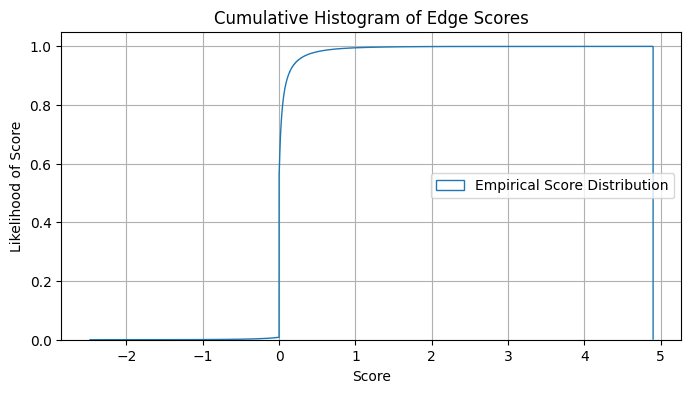

In [27]:
fKG.plot_score_histogram(edge_types=[("gene", "gene")])

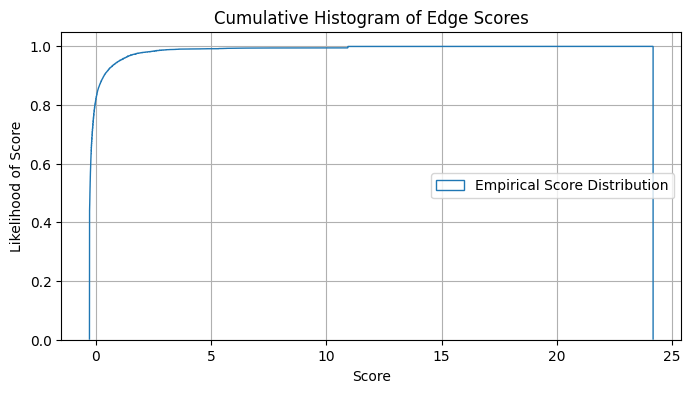

In [23]:
fKG.plot_score_histogram(edge_types=[("drug", "disease")],score_accessor=lambda x: x.get("score_zscore", 0))

In [24]:
! pwd

/home/ubuntu/git/mikg/scripts


In [25]:
mNS = MeanNetworkScorer()

Adipocyte
Adipocyte Adipocyte_CTRL
DiGraph with 2016 nodes and 7347 edges


/home/ubuntu/git/mikg/scripts/../mikg/kgraph.py:1069: RuntimeWarning: divide by zero encountered in scalar divide
  logFC = np.log2(np.median(commScores[x]) / np.median(ownScores))


Adipocyte Adipocyte_RZ
DiGraph with 2235 nodes and 9202 edges
Adipocyte Adipocyte_BZ
DiGraph with 1838 nodes and 6587 edges
Adipocyte Adipocyte_IZ
DiGraph with 1275 nodes and 3456 edges
Adipocyte Adipocyte_FZ
DiGraph with 2393 nodes and 10014 edges
9
Adipocyte_CTRL_mod_23 49
Input Graph Nodes 49
Extended Graph Nodes 40
Extended Graph Edges 182
TBXAS1 --> CHEMBL11662 {'type': 'drug', 'source': 'opentargets', 'name': 'OZAGREL', 'drug_type': 'Small molecule', 'score': 0.12241247888906497, 'disease_spec': 0.9226527233569728, 'disease_spec_zscore': 0.6406670838213926}
TBXAS1 --> CHEMBL281398 {'type': 'drug', 'source': 'opentargets', 'name': 'TERBOGREL', 'drug_type': 'Small molecule', 'score': 0.06120623944453248, 'disease_spec': 1.0, 'disease_spec_zscore': 1.1947475598500075}
PPARG --> CHEMBL1762621 {'type': 'drug', 'source': 'opentargets', 'name': 'BARDOXOLONE METHYL', 'drug_type': 'Small molecule', 'score': 1.0046307031885282, 'disease_spec': 0.7548149339757931, 'disease_spec_zscore': -0.

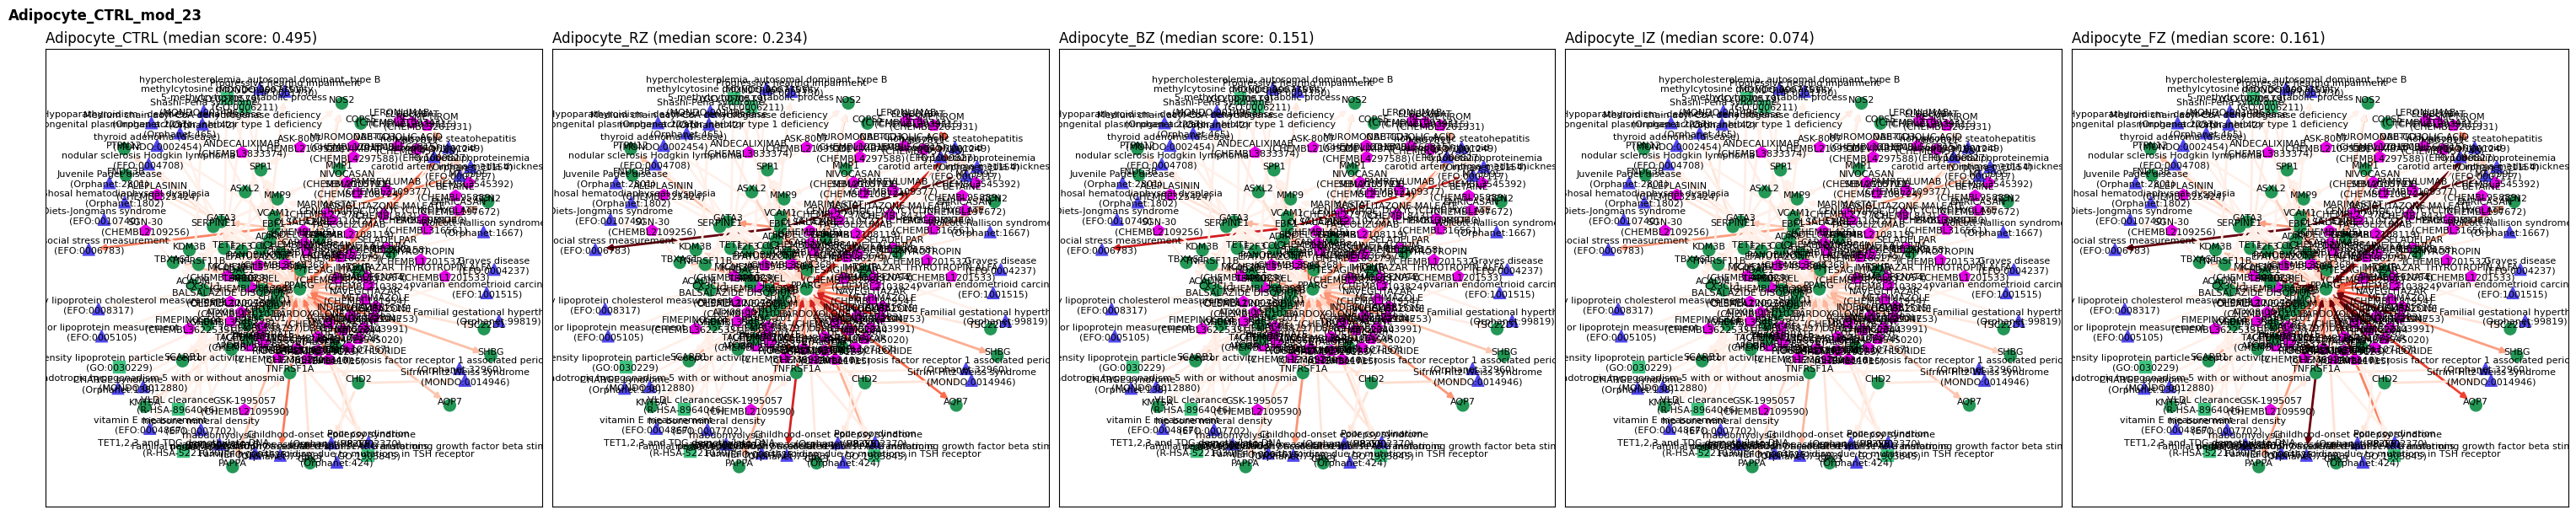

Cardiomyocyte
Cardiomyocyte Cardiomyocyte_CTRL
DiGraph with 2100 nodes and 7629 edges
Cardiomyocyte Cardiomyocyte_RZ
DiGraph with 1836 nodes and 6290 edges
Cardiomyocyte Cardiomyocyte_BZ
DiGraph with 1993 nodes and 7212 edges
Cardiomyocyte Cardiomyocyte_IZ
DiGraph with 1582 nodes and 5251 edges


/home/ubuntu/git/mikg/scripts/../mikg/kgraph.py:1069: RuntimeWarning: divide by zero encountered in scalar divide
  logFC = np.log2(np.median(commScores[x]) / np.median(ownScores))


Cardiomyocyte Cardiomyocyte_FZ
DiGraph with 2234 nodes and 8333 edges
3
Cardiomyocyte_IZ_mod_6 63
Input Graph Nodes 63
Extended Graph Nodes 184
Extended Graph Edges 845
IL3RA --> CHEMBL4297573 {'type': 'drug', 'source': 'opentargets', 'name': 'TAGRAXOFUSP', 'drug_type': 'Protein', 'score': 0.14821112394438657, 'disease_spec': 0.8453054467139456, 'disease_spec_zscore': 0.08658660779277759}
IL3RA --> CHEMBL2109327 {'type': 'drug', 'source': 'opentargets', 'name': 'CSL-360', 'drug_type': 'Antibody', 'score': 0.13483235262419938, 'disease_spec': 1.0, 'disease_spec_zscore': 1.1947475598500075}
GHR --> CHEMBL1201515 {'type': 'drug', 'source': 'opentargets', 'name': 'PEGVISOMANT', 'drug_type': 'Protein', 'score': 0.9650073131324862, 'disease_spec': 0.7548149339757931, 'disease_spec_zscore': -0.5616459939241563}
IFNLR1 --> CHEMBL2108723 {'type': 'drug', 'source': 'opentargets', 'name': 'PEGINTERFERON LAMBDA-1A', 'drug_type': 'Protein', 'score': 0.05209102759611046, 'disease_spec': 0.8000601903

In [ ]:
basedir = "/home/ubuntu/git/mikg/MI_output"

for x in glob.glob("{}/*/*".format(basedir)):
    #print("Removing", x)
    os.remove(x)

sigKGraphs = {}

for tissue in tissue2zone2kg:
    print(tissue)
    
    zoneSort = {
        "CTRL": 0,
        "RZ": 1,
        "BZ": 2,
        "IZ": 3,
        "FZ": 4
    }
    
    tissueKGs = tissue2zone2kg[tissue]
    
    sTZ = sorted([x for x in tissueKGs], key=lambda x: zoneSort.get(x.split("_")[1], -1))
    
    sTissueKGs = {x: tissueKGs[x] for x in sTZ}
    
    dmi = DifferentialModuleIdentifier()
    
    all_comms = {}
    for zone in sTissueKGs:
        print(tissue, zone)
        gene_kg = sTissueKGs[zone].to_gene_kgraph()
        
        zone_comms = gene_kg.get_communities(minEdgeScore = 0.5, resolution=4, prefix="{}_mod".format(zone))
        sigcomm = dmi.identify_differential_communities(zone_comms, zone, sTissueKGs, verbose=False, min_enriched=0.9, minLogFC=-1)   
        
        for x in sigcomm:
            all_comms[x] = zone_comms[x]
        
    print(len(all_comms))

    for comm in all_comms:
        print(comm, len(all_comms[comm]))
        
                
        
        nwe = NetworkExtender()
        eKG = nwe.extend_network(all_comms[comm], sTissueKGs[zone], verbose=False, min_children_gs=3)
        
        nwe.extend_network_force(eKG, sTissueKGs[zone], "drug",
                                 acceptor=lambda n, k: k.kg.nodes[n].get("disease_spec", 1) >= 0.7, # only disease-specific drugs
                                 edge_acceptor=lambda e, k: k.kg.edges[e].get("score", 1) > 0.1 and not (k.kg.edges[e].get("evidence_status", "") in ["Withdrawn"]) # no withdrawn drugs
                                 )
        
        #eKG.plot_graph()
        
        outdir = os.path.join(basedir, tissue)
        os.makedirs(outdir, exist_ok=True)
        outdir = os.path.join(outdir, comm)
        dmi.plot_communities(sTissueKGs, [eKG.kg.nodes], zone, main_net=[all_comms[comm]], font_size=6, titles=[comm], num_columns=5, outfile=outdir)
        
        sigKGraphs[comm] = eKG

        break
            

In [ ]:
[x for x in sigKGraphs]

In [ ]:
import pickle

with open("zone_sigkgs.pickle", 'wb') as f:
    
    for x in sigKGraphs:
        sigKGraphs[x].kg = sigKGraphs[x].kg.copy()
    
    pickle.dump(sigKGraphs, f)

In [ ]:
##
##
##
#  AND MAYBE HERE
##
##
##

In [ ]:
sigKGraphs = pickle.load(open("zone_sigkgs.pickle", "rb"))

In [ ]:
[x for x in sigKGraphs]

In [ ]:
fKG.get_node_edges("Orphanet:59135")

In [ ]:
fKG.kg.nodes["Orphanet:59135"]

In [ ]:
fKG.kg.nodes["MYH7"]

In [ ]:
node="Orphanet:59135"
target_ntype="gene"
child_score_accessor=lambda x: x.get("expression", {}).get("score", 0)

#get all children of node of type target_ntype
geneChildren = fKG._get_predecessors(node, target_ntype)

#get all scores for children
childrenScores = []
for child in geneChildren:
    childrenScores.append( child_score_accessor(fKG.kg.nodes[child]) )

    
if len(childrenScores) == 0:
    nodeMedian = 0
    nodeScore = 0    
else:
    nodeScore = np.mean(childrenScores)
    nodeSD = np.std(childrenScores)
    nodeMedian = np.median(childrenScores)
    
print(nodeMedian)

In [ ]:
diseaseDegrees = fKG.get_node_degrees("disease")

In [ ]:
plt.hist(diseaseDegrees, bins=100)

In [ ]:
skg = sigKGraphs["Adipocyte_CTRL_mod_22"]

In [ ]:
def get_edges_of_node(kg, node):
    
    allEdges = []
    for inEdge in kg.in_edges(node):
        oNode = inEdge[0]
        allEdges.append(oNode)
            
    for outEdge in kg.out_edges(node):
        oNode = outEdge[1]
        allEdges.append(oNode)
                    
    return allEdges

In [ ]:
get_edges_of_node(skg, "Orphanet:725")